In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

/Users/alexander-fischer/miniconda3/envs/rob_vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# defining parameters for the data loader
base_data_path = os.path.join(os.getcwd(), 'data')
batch_size = 4

test_percentage = 0.1
val_percentage = 0.2

### Loading the data

In [3]:
## create dataloader for the dataset
class RoadSign_Dataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.class_labels = ['speedlimit', 'trafficlight', 'crosswalk', 'stop']
        self.images_folder = os.path.join(data_folder, 'images')
        self.annotations_folder = os.path.join(data_folder, 'annotations')
        self.file_list = os.listdir(self.images_folder)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.images_folder, img_name)
        annotation_path = os.path.join(self.annotations_folder, img_name.replace('.png', '.xml'))

        # Read image
        img = Image.open(img_path).convert("RGB")

        # Apply transform
        if self.transform:
            img = self.transform(img)

        # Parse XML file
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Extract class label
        object_elem = root.find('object')
        class_label = object_elem.find('name').text
        class_label = self.class_labels.index(class_label)

        return img, class_label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((400, 300))
])

dataset = RoadSign_Dataset(data_folder=base_data_path, transform=transform)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# # test dataloader
# for data, labels in dataloader:
#     print("Batch shape:", data.shape)
#     print("Label shape:", labels.shape)
#     print("Label values:", labels)
#     break

### Splitting the data into train, validation and test sets

In [4]:
## create split into train, val and test
dataset_indices = list(range(0, len(dataset)))
dataset_labels = [label for _, label in dataset]

# split dataset into train and test, but keep the same proportion of each class
train_indices, test_indices = train_test_split(dataset_indices, test_size=test_percentage, random_state=42, stratify=dataset_labels)
train_labels = [dataset_labels[i] for i in train_indices]
train_indices, val_indices = train_test_split(train_indices, test_size=val_percentage, random_state=42, stratify=train_labels)

print(f"Train dataset size: {len(train_indices)}, account for {len(train_indices)/len(dataset_indices)*100} % of the dataset")
print(f"Validation dataset size: {len(val_indices)}, account for {len(val_indices)/len(dataset_indices)*100} % of the dataset")
print(f"Test dataset size: {len(test_indices)}, account for {len(test_indices)/len(dataset_indices)*100} % of the dataset")

## create dataloader for the train, val and test dataset
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

Train dataset size: 2160, account for 72.0 % of the dataset
Validation dataset size: 540, account for 18.0 % of the dataset
Test dataset size: 300, account for 10.0 % of the dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


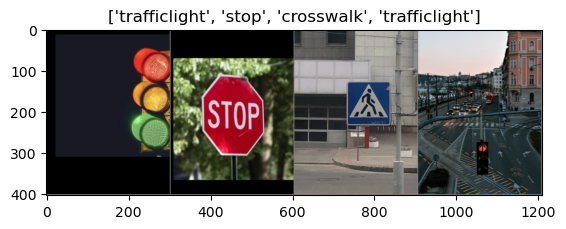

In [12]:
# Visualize a batch of images
def imshow(img, title=None):
    img = img / 2 + 0.5 # unnormalize image: [-1, 1] -> [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, axes=(1, 2, 0)))
    # plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.savefig(os.path.join(base_data_path, 'sample_test.png'))
    plt.show()

# get some random training images
images, labels = next(iter(test_dataloader))

# show images
out = make_grid(images)

imshow(out, title=[dataset.class_labels[x] for x in labels])

### Copying the test set to the test folder (for later image corruption experiments)

In [6]:
import shutil

# Create the test_images folder
test_folder = os.path.join(base_data_path, 'test_images')
test_img_folder = os.path.join(test_folder, 'images')
test_ann_folder = os.path.join(test_folder, 'annotations')
if os.path.exists(test_folder):
    shutil.rmtree(test_folder)
os.makedirs(test_img_folder)
os.makedirs(test_ann_folder)

# Function to copy images from source to destination
def copy_images(src_folder, dest_folder, img_list):
    annot_list = [file_name.replace('.png', '.xml') for file_name in img_list]
    src_annot_folder = os.path.join(src_folder.replace('images', 'annotations'))
    
    for img_name, annot_name in zip(img_list, annot_list):
        src_img_path = os.path.join(src_folder, img_name)
        src_annot_path = os.path.join(src_annot_folder, img_name.replace('.png', '.xml'))
        dest_img_path = os.path.join(dest_folder, img_name)
        dest_annot_path = os.path.join(test_ann_folder, annot_name)
        shutil.copy(src_img_path, dest_img_path)
        shutil.copy(src_annot_path, dest_annot_path)

# Extract all images from the test set and copy them to the test_images folder
copy_images(dataset.images_folder, test_img_folder, [dataset.file_list[i] for i in test_indices])

# test
assert len(test_indices) == len(os.listdir(test_img_folder))

### Corrupt test image set

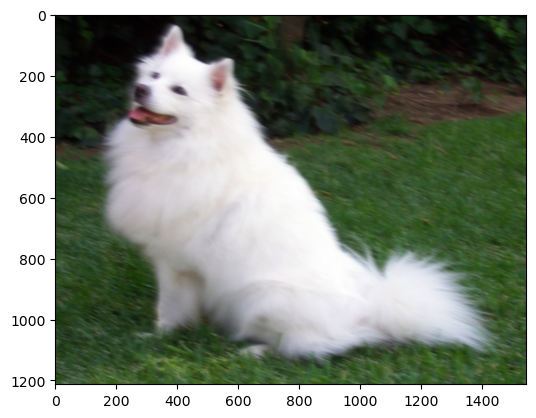

In [7]:
from imagecorruptions import corrupt

# Load the original test image
image_path = os.path.join(base_data_path, 'dog.jpg')
original_image = np.array(Image.open(image_path))

# Apply motion blur with severity 1
corrupted_image = corrupt(original_image, corruption_name='motion_blur', severity=5)

plt.imshow(corrupted_image)

# save the corrupted test image
corrupted_image_path = os.path.join(base_data_path, 'corrupted_dog.jpg')
Image.fromarray(corrupted_image).save(corrupted_image_path)

In [10]:
## now, loop through all the images in the test images folder and apply the corruptions 'motion_blur', 'fog', 'frost', 'snow' and save the images in the corresponding folders named after the corruption type
corruption_types = ['motion_blur', 'fog', 'frost', 'snow']
corruption_levels = [1, 3, 5]

# Create the corrupted images folder
for corruption in corruption_types:
    corruption_base_folder = os.path.join(test_folder, 'corruptions', f'{corruption}')
    for level in corruption_levels:
        corruption_img_folder = os.path.join(corruption_base_folder, f'severity_{level}')
        if os.path.exists(corruption_img_folder):
            shutil.rmtree(corruption_img_folder)
        os.makedirs(corruption_img_folder)

# Function to copy images from source to destination
def corrupt_images(src_folder, dest_folder, img_list, corruption, level):
    for img_name in img_list:
        src_img_path = os.path.join(src_folder, img_name)
        dest_img_path = os.path.join(dest_folder, img_name)
        original_image = np.array(Image.open(src_img_path).convert("RGB"))
        corrupted_image = corrupt(original_image, corruption_name=corruption, severity=level)
        Image.fromarray(corrupted_image).save(dest_img_path)

for corruption in corruption_types:
    for level in corruption_levels:
        corruption_base_folder = os.path.join(test_folder, 'corruptions', f'{corruption}')
        corruption_img_folder = os.path.join(corruption_base_folder, f'severity_{level}')
        corrupt_images(test_img_folder, corruption_img_folder, os.listdir(test_img_folder), corruption, level)

        print(f"Corrupted images for {corruption} with severity {level} created!")
    print("")

Corrupted images for motion_blur with severity 1 created!
Corrupted images for motion_blur with severity 3 created!
Corrupted images for motion_blur with severity 5 created!

Corrupted images for fog with severity 1 created!
Corrupted images for fog with severity 3 created!
Corrupted images for fog with severity 5 created!

Corrupted images for frost with severity 1 created!
Corrupted images for frost with severity 3 created!
Corrupted images for frost with severity 5 created!

Corrupted images for snow with severity 1 created!
Corrupted images for snow with severity 3 created!
Corrupted images for snow with severity 5 created!

